In [1]:
# Import Libraries #
import findspark
findspark.init()
from pyspark.sql.functions import split, col, array_contains, translate, round, size, when, udf, lit, mean, count, format_number, collect_list
from pyspark.sql.types import TimestampType, MapType, IntegerType, StringType, ArrayType, FloatType, StructField, StructType
from pyspark.sql import SparkSession
from helper import *

In [2]:
spark = SparkSession.builder.appName('test').master("yarn") \
.config("spark.executor.instances", 9) \
.config("spark.executor.memory", "1G")  \
.config("spark.ui.port", 8080) \
.getOrCreate()

2023-04-23 23:08:25,751 INFO spark.SparkContext: Running Spark version 3.3.2
2023-04-23 23:08:26,225 INFO resource.ResourceUtils: ==============================================================
2023-04-23 23:08:26,227 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2023-04-23 23:08:26,230 INFO resource.ResourceUtils: ==============================================================
2023-04-23 23:08:26,231 INFO spark.SparkContext: Submitted application: test
2023-04-23 23:08:26,266 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2023-04-23 23:08:26,293 INFO resource.ResourceProfile: Limiting resource is cpus at 1 tasks per executor
2023-04-23 23:08:26,300 INFO resource.ResourceProfileManager: Added Resou

In [3]:
## MUTE OUTPUT FROM SPARK
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.OFF)
logger.LogManager.getLogger("akka").setLevel(logger.Level.OFF)
spark.conf.set("spark.driver.log.level", "OFF")

In [4]:
spark

In [5]:
#Event, White, Black, Result, WhiteElo, BlackElo, Opening, TimeControl, Termination, Moves,Eval, UTCTimestamp
schema = StructType([ \
    StructField("Event",StringType(),True), \
    StructField("White",StringType(),True), \
    StructField("Black",StringType(),True), \
    StructField("Result", StringType(), True), \
    StructField("WhiteElo", IntegerType(), True), \
    StructField("BlackElo", IntegerType(), True), \
    StructField("Opening",StringType(),True), \
    StructField("TimeControl",StringType(),True), \
    StructField("Termination",StringType(),True), \
    StructField("Moves", StringType(), True), \
    StructField("Eval", StringType(), True), \
    StructField("UTCTimestamp", TimestampType(), True) \
  ])
df = spark.read.csv("hdfs://namenode:9000/chess_2016_dataset/output/part*", schema=schema)

##### Check Shape of Data

In [6]:
print("shape: ", (df.count(), len(df.columns)))

shape:  (311321, 12)


##### Convert columns to appropriate types

In [7]:
df = convert_types(df)
df.dtypes

[('Event', 'string'),
 ('White', 'string'),
 ('Black', 'string'),
 ('Result', 'string'),
 ('WhiteElo', 'int'),
 ('BlackElo', 'int'),
 ('Opening', 'string'),
 ('TimeControl', 'string'),
 ('Termination', 'string'),
 ('Moves', 'array<string>'),
 ('Eval', 'array<float>'),
 ('UTCTimestamp', 'timestamp')]

In [8]:
eval_difference = 3.0
eval_games = df.where(col("Eval")[0].isNotNull())
eval_games = eval_games.withColumn("WhiteBlunders", (find_white_blunders(col("Eval"), lit(eval_difference))))
eval_games = eval_games.withColumn("BlackBlunders", (find_black_blunders(col("Eval"), lit(eval_difference))))
eval_games.select("TimeControl", "White", "WhiteElo", "WhiteBlunders", "Black", "BlackElo", "BlackBlunders", "Result", "Termination") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(10).toPandas().head(10)

,TimeControl,White,WhiteElo,WhiteBlunders,Black,BlackElo,BlackBlunders,Result,Termination
0,300+5,dynamo21,1649,19,viviero,1705,14,1/2-1/2,Normal
1,300+0,TulatovOleg,1962,15,bart2008,1555,8,0-1,Normal
2,60+0,mrkile,1635,14,chessrok2000,1340,12,1-0,Time forfeit
3,300+0,barcoalado,1690,13,iltug,1645,15,1/2-1/2,Normal
4,480+3,ali131313,1863,12,tarsis,2101,15,1-0,Normal
5,600+0,catyx97,1438,12,dimonchik-com,1307,10,1-0,Normal
6,600+0,dwp5321,1362,12,jujugaga,1295,9,1/2-1/2,Normal
7,45+3,Reedplate,1242,12,heras11,1229,6,1/2-1/2,Normal
8,600+30,bashbrisecul,1249,11,mica44110,1203,11,0-1,Normal
9,600+0,ABL,1315,11,EugeneCareful,1530,7,0-1,Normal


##### Plot Most Blundered Game

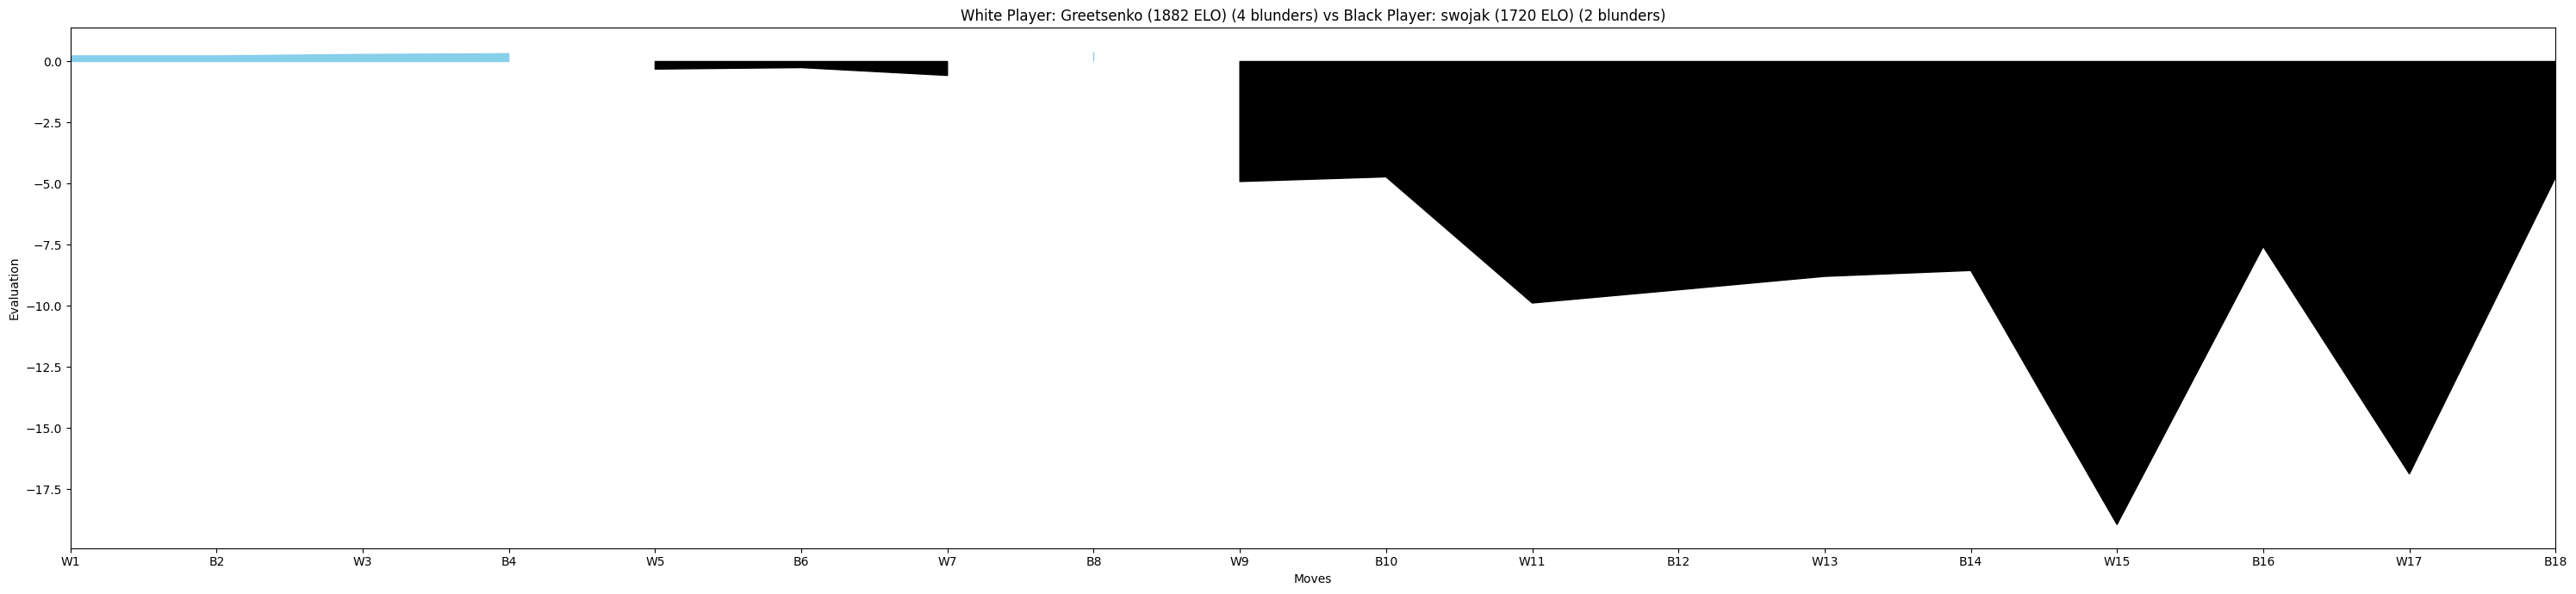

In [9]:
plot_eval_game(eval_games)

### Group By
- Time control ~ (60, 120, 180, 600) etc...
- Elo-Brackets ~ ([1200, 1400], [1500, 1700], [2000-2200]) etc...

#### Time Control Grouping

In [10]:
time_control_white_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders"), count("TimeControl")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

time_control_black_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("BlackBlunders"), count("TimeControl")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))


In [11]:
time_control_white_blunders_averages \
    .orderBy(col("avg(WhiteBlunders)").desc()) \
    .where(col("count(TimeControl)")>1000) \
    .limit(10) \
    .toPandas() \
    .head()

,TimeControl,avg(WhiteBlunders),count(TimeControl)
0,30+0,1.8,1780
1,60+0,1.6,9095
2,900+0,1.5,1106
3,180+0,1.4,3656
4,600+0,1.4,2994


In [12]:
time_control_black_blunders_averages \
    .orderBy(col("avg(BlackBlunders)").desc()) \
    .where(col("count(TimeControl)")>1000) \
    .limit(10) \
    .toPandas() \
    .head()

,TimeControl,avg(BlackBlunders),count(TimeControl)
0,30+0,1.8,1780
1,60+0,1.6,9095
2,600+0,1.5,2994
3,900+0,1.5,1106
4,120+0,1.4,1114


#### Elo Brackets Grouping

Start off by Creating a new spark daraframe column called "EloBracket" which we will later use to group and aggregrate by. When grouping the players by elo brackets we want to use a range that makes sense such that there are not 1 bracket that contains 80% of the playerbase and ones that only contain a small fraction. E.g We want evenly distributed amount of players in each bracket (as far as that is possible).

/tmp/ipykernel_397618/1011671360.py:5: UserWarning:                             

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(elo_list, kde=True, color ='green', bins=20)


<Axes: ylabel='Density'>

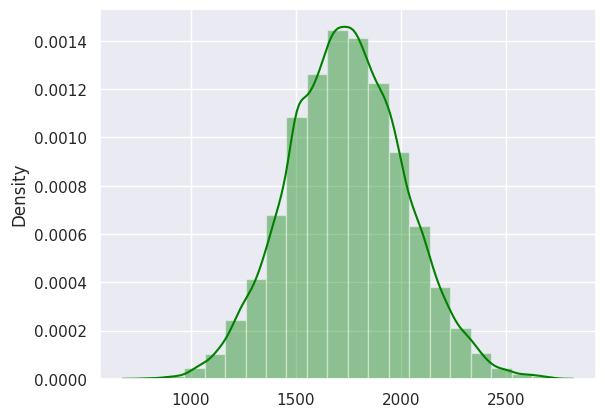

In [13]:
# Start by getting all the elo column values in the dataframe.
elo_list = eval_games.select(collect_list("WhiteElo")).first()[0]
sns.set_theme(style="ticks")
sns.set_style('darkgrid')
sns.distplot(elo_list, kde=True, color ='green', bins=20)

"EloBracket" column should be of type String and contain values in format: "0-1200", "1200-1600", "1600-2000", "2000-3000"

In [14]:
eval_games = eval_games.withColumn("EloBracket", \
                         when((0 < eval_games.WhiteElo) & (eval_games.WhiteElo < 1500), lit("<1500")) \
                        .when((1500 <= eval_games.WhiteElo) & (eval_games.WhiteElo <= 1750), lit("1500-1750")) \
                        .when((1750 < eval_games.WhiteElo) & (eval_games.WhiteElo <= 2000), lit("1751-2000")) \
                        .otherwise(lit(">2000")))

In [15]:
eval_games.show()

+--------------------+-------------+---------------+------+--------+--------+--------------------+-----------+------------+--------------------+--------------------+-------------------+-------------+-------------+----------+
|               Event|        White|          Black|Result|WhiteElo|BlackElo|             Opening|TimeControl| Termination|               Moves|                Eval|       UTCTimestamp|WhiteBlunders|BlackBlunders|EloBracket|
+--------------------+-------------+---------------+------+--------+--------+--------------------+-----------+------------+--------------------+--------------------+-------------------+-------------+-------------+----------+
|Rated Blitz tourn...|     chm00002|         wojda4|   1-0|    1728|    1796|   Caro-Kann Defense|      180+0|      Normal|['e4',  'c6',  'N...|[0.25, 0.43, 0.26...|2016-05-01 14:49:16|            2|            5| 1500-1750|
|Rated Classical game|Rodrigo_cuezy|         dnzbod|   0-1|    1628|    1643|Philidor Defense:...|  

In [16]:
elo_bracket_white_blunders_averages = eval_games \
    .groupBy("EloBracket") \
    .agg(mean("WhiteBlunders"), count("EloBracket")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

elo_bracket_black_blunders_averages = eval_games \
    .groupBy("EloBracket") \
    .agg(mean("BlackBlunders"), count("EloBracket")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))

In [17]:
elo_bracket_white_blunders_averages.orderBy(col("avg(WhiteBlunders)").desc()).limit(10).toPandas().head()

,EloBracket,avg(WhiteBlunders),count(EloBracket)
0,<1500,1.9,7396
1,1500-1750,1.5,13412
2,1751-2000,1.3,12436
3,>2000,1.1,6709


In [18]:
elo_bracket_black_blunders_averages.orderBy(col("avg(BlackBlunders)").desc()).limit(10).toPandas().head()

,EloBracket,avg(BlackBlunders),count(EloBracket)
0,<1500,1.7,7396
1,1500-1750,1.6,13412
2,1751-2000,1.5,12436
3,>2000,1.4,6709


In [19]:
a = eval_games.select("Moves") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()) \
    .limit(1) \
    .take(1)[0][0]
print([x.replace("'","").replace('"', "").strip("'") for x in a])

['e4', ' e5', ' Nf3', ' Nc6', ' Bc4', ' h6', ' d3', ' Nf6', ' Nc3', ' d6', ' Be3', ' Bg4', ' Qe2', ' a6', ' h3', ' Bxf3', ' Qxf3', ' b5', ' Nd5', ' bxc4', ' Nxf6+', ' Qxf6', ' Qxf6', ' gxf6', ' dxc4', ' Nb4', ' O-O-O', ' Nxa2+', ' Kb1', ' Nb4', ' c3', ' Nc6', ' f4', ' Bg7', ' f5', ' O-O', ' h4', ' Rfb8', ' g4', ' Na5', ' c5', ' Bf8', ' cxd6', ' Bxd6', ' g5', ' Nc4', ' Bc1', ' Ba3', ' Ka2', ' Bxb2', ' Bxb2', ' Rxb2+', ' Ka1', ' Kg7', ' gxh6+', ' Kxh6', ' Rhg1', ' Re2', ' Rd7', ' Rf8', ' Rxc7', ' Ne3', ' Rb1', ' Nc2+', ' Ka2', ' Ne3+', ' Ka3', ' Kh5', ' Rbb7', ' Nc2+', ' Ka4', ' Kxh4', ' Rxf7', ' Rxf7', ' Rxf7', ' Kg5', ' c4', ' Rxe4', ' Ka5', ' Rxc4', ' Kxa6', ' Ra4+', ' Kb5', ' Rb4+', ' Kc5', ' Rf4', ' Kd6', ' Kxf5', ' Ke7', ' Ke4', ' Ke6', ' Nd4+', ' Kd6', ' Kf5', ' Kd5', ' Nb5', ' Rb7', ' Nc3+', ' Kd6', ' Ne4+', ' Ke7', ' Nc5', ' Rb6', ' e4', ' Rxf6+', ' Kg5', ' Rc6', ' Nd3', ' Rc4', ' Nf2', ' Ke6', ' Kg4', ' Rc3', ' Nd1', ' Rc2', ' Rf3', ' Ke5', ' e3', ' Re2', ' Nc3', ' Kd4', ' Nd1'

## BIG HEAVY FOOKIN WORK

### Move List to FEN notation
ta den lista me moves som input, lag en FEN string.


In [20]:
rows = eval_games.select("Moves").take(1)
moves = rows[0].Moves
moves

["'e4'",
 " 'c6'",
 " 'Nf3'",
 " 'd5'",
 " 'e5'",
 " 'e6'",
 " 'd4'",
 " 'Ne7'",
 " 'Bd3'",
 " 'c5'",
 " 'dxc5'",
 " 'Nd7'",
 " 'Be3'",
 " 'Qc7'",
 " 'b4'",
 " 'Nxe5'",
 " 'Nxe5'",
 " 'Qxe5'",
 " 'Bb5+'",
 " 'Bd7'",
 " 'Bxd7+'",
 " 'Kxd7'",
 " 'Qd4'",
 " 'Ng6'",
 " 'O-O'",
 " 'Qxd4'",
 " 'Bxd4'",
 " 'e5'",
 " 'Bb2'",
 " 'a5'",
 " 'b5'",
 " 'Bxc5'",
 " 'Nd2'",
 " 'b6'",
 " 'c4'",
 " 'd4'",
 " 'Ne4'",
 " 'Nf4'",
 " 'Nxc5+'",
 " 'bxc5'",
 " 'Ba3'",
 " 'Kd6'",
 " 'Rab1'",
 " 'Rhc8'",
 " 'g3'",
 " 'Nd3'",
 " 'Rfd1'",
 " 'Nb4'",
 " 'f4'",
 " 'e4'",
 " 'g4'",
 " 'e3'",
 " 'f5'",
 " 'Nxa2'",
 " 'Rf1'",
 " 'Nc3'",
 " 'Rbc1'",
 " 'e2'",
 " 'Rf4'",
 " 'Re8'",
 " 'Rxd4+'",
 " 'Ke5'",
 " 'Rd2'",
 " 'Kf6'",
 " 'Bb2'",
 " 'e1=Q+'",
 " 'Rxe1'",
 " 'Rxe1+'",
 " 'Kf2'",
 " 'Rae8'",
 " 'Bxc3+'",
 " 'Kg5'",
 " 'Bxa5'",
 " 'Rh1'",
 " 'Kg3'",
 " 'Re3+'",
 " 'Kg2'",
 " 'Rd1'",
 " 'Rxd1'"]

### First moves
kan bruk d me elo og result for å se ka som e vanlig for good players

In [21]:
rows = eval_games.select("Result", "WhiteElo", "BlackElo", "Moves").take(100)

first_moves = []
for row in rows: 
    move = row.Moves[:2]
    first_move = [row.Result, row.WhiteElo, row.BlackElo, move]
    first_moves.append(first_move)

first_moves

[['1-0', 1728, 1796, ["'e4'", " 'c6'"]],
 ['0-1', 1628, 1643, ["'e4'", " 'e5'"]],
 ['1-0', 2151, 1823, ["'e4'", " 'd5'"]],
 ['0-1', 1599, 1963, ["'d4'", " 'Nf6'"]],
 ['0-1', 1943, 1968, ["'g3'", " 'd5'"]],
 ['1-0', 1676, 1532, ["'e4'", " 'd5'"]],
 ['1-0', 1732, 1436, ["'Nc3'", " 'e5'"]],
 ['1-0', 2026, 2079, ["'d4'", " 'Nf6'"]],
 ['1-0', 1549, 1413, ["'e4'", " 'e5'"]],
 ['1-0', 1996, 1892, ["'d4'", " 'e6'"]],
 ['0-1', 1890, 2267, ["'d4'", " 'f5'"]],
 ['1-0', 1429, 1151, ["'e4'", " 'c5'"]],
 ['0-1', 1522, 1669, ["'f4'", " 'd5'"]],
 ['0-1', 1246, 1354, ["'e4'", " 'e5'"]],
 ['1-0', 1827, 1898, ["'e4'", " 'c5'"]],
 ['1-0', 1802, 1800, ["'d4'", " 'f5'"]],
 ['1-0', 1684, 1283, ["'d4'", " 'Nf6'"]],
 ['0-1', 1788, 1773, ["'e4'", " 'e6'"]],
 ['0-1', 1590, 1685, ["'d4'", " 'd5'"]],
 ['0-1', 1530, 1528, ["'e4'", " 'Nc6'"]],
 ['1-0', 1634, 1544, ["'e4'", " 'e5'"]],
 ['0-1', 1186, 1496, ["'e4'", " 'e5'"]],
 ['1/2-1/2', 2009, 1734, ["'d4'", " 'c6'"]],
 ['0-1', 1500, 1902, ["'e4'", " 'd5'"]],
 ['0-1'